In [ ]:
# import core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.9.2


In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 766 kB/s 


In [ ]:
# load Keras libraries
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Wed Nov 23 22:32:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# load the model
model_file = '/content/LSTM_transfer_model_Gen4 - retry.h5'
model = load_model(model_file)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        309248      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate_1 (Concatenate)    (None, 512)          0           ['lstm_2[0][1]',                 
                                                                  'lstm_2[0][2]']           

In [ ]:
import pickle

In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'rb') as fp:
        #smiles = pickle.load(fp)
        smiles = np.array([r.rstrip() for r in fp])
    return smiles

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [ ]:
# load transfer learning dataset
smifile = '/content/nextgen_smiles_cleanedv4 - retry'
data = load_data(smifile)
data = [mol.decode() for mol in data if len(mol) < 99]
data = np.array(data)
print("Training dataset shape:", data.shape)
print("Sample training smile: \n", data[2])

Training dataset shape: (379,)
Sample training smile: 
 c1c2c(OCc3ccccc3cnc3c2c1)NCC3


In [ ]:
# load the Python dictionaries that map characters-to-integers and integers-to-characters
d1 = '/content/char_to_int (1).json'
d2 = '/content/int_to_char (1).json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

In [ ]:

# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y dataset
embed = 101
X_train, y_train = vectorize(data, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)

In [ ]:
# train the model on the transfer learning dataset
batch_size = 16
nb_epochs = 225 // 4
model.fit([X_train, X_train], y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/56
24/24 [==============================] - 2s 18ms/step - loss: 0.1562 - acc: 0.9605
Epoch 2/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0884 - acc: 0.9727
Epoch 3/56
24/24 [==============================] - 0s 13ms/step - loss: 0.0488 - acc: 0.9842
Epoch 4/56
24/24 [==============================] - 0s 15ms/step - loss: 0.0227 - acc: 0.9922
Epoch 5/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0135 - acc: 0.9960
Epoch 6/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0079 - acc: 0.9983
Epoch 7/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0038 - acc: 0.9994
Epoch 8/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0019 - acc: 1.0000
Epoch 9/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0014 - acc: 1.0000
Epoch 10/56
24/24 [==============================] - 0s 14ms/step - loss: 0.0011 - acc: 1.0000
Epoch 11/56
24/24 [==============================] - 0s 14m

In [ ]:
# save our transfer learning model & weights
mod_file = 'LSTM_transfer_model_Gen5 - retry.h5'
model.save(mod_file)
print("Model Saved")

In [ ]:
#TEMPORARY CODE
#model.load_weights('/content/QED Run 1 - 99.86 Test Acc.h5')
#model.load_weights('/content/LSTM_transfer_model.h5')

In [ ]:

# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

In [ ]:

# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

In [ ]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [ ]:
# transfer the weights from the transfer learning model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
#gen_model.save("/drive/My Drive/chem_data/gen_model.h5")
gen_model.summary()

In [ ]:

# create our Softmax sampling function
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent, verbose = 0)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec, verbose=0)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

In [ ]:
# create the latent space
latent_space = encoder_model.predict(X_train, verbose=0)
print(f'Latent space shape: {latent_space.shape}')

In [ ]:
# smile generation from the latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(data[0])

In [ ]:
# smile generation from the latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(latent_space[1:2], n_vocab, sampling_temp)
print(test_smile)
print(data[1])

In [ ]:
import rdkit.Chem.QED as QED
import rdkit.Chem as Chem

In [ ]:
# check percentage of malformed smiles generated using a baseline sampling temperature
sampling_temp = 1.0
wrong_format = 0
sub_threshold = 0
for i in range(100):
    print("Run #" + str(i))
    smiles = sample_smiles(latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        if QED.qed(mol) >= 0.766:
          print(QED.qed(mol))
        else:
          sub_threshold += 1
          print("sub-threshold:" + str(sub_threshold))
    else:
        wrong_format += 1
        sub_threshold += 1
        print("wrongly formatted: " + str(wrong_format))
        print("sub-threshold:" + str(sub_threshold))
print("%0.1F percent wrongly formatted smiles"%(wrong_format/float(100)*100))
print("%0.1F percent sub-0.766 QED smiles"%(sub_threshold/float(100)*100))

In [ ]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      print(out)
      mols.append(mol)
      samples.append(out)
  return mols, samples

In [ ]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[50:51]
sampling_temp =  0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)

In [ ]:
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [ ]:
print(f'Sampled SMILES:\n {t_smiles}')

In [ ]:
if t_smiles:
  for mol in t_smiles:
    print(QED.qed(Chem.MolFromSmiles(mol)))

In [ ]:
import random
# create a for loop to generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
num_to_generate = latent_space.shape[0] - 1
for i in range(num_to_generate):
  print('Run #' + str(i))
  seed_value = random.randint(0, latent_space.shape[0]-2)
  latent_seed = latent_space[seed_value:seed_value+1]
  sampling_temp = rn.uniform(0.75 ,1.26)
  scale = 0.75
  quantity = 50
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

Run #0
Oc1cc2cc3cccc(c23)CNCCO1.Cl
OC(/C=CC1CCC2OO[C@@]2=C1O)C(C)I
NCCC=NC1CONc2ccccc2[C@@H]CN1/C
CCNc1nc2c(C(Cn3nncc3)sc2CCN)cs1
CNCCC1NCN2/c3ccc4c3c2CCN4CCCC1
Oc1(C(F)O)C2C1=CSN=N2.CN[C@H]
CCNCC1=O.c2c3n2CCC31CC
Run #1
C(C)c1[N+]2CC[C@H]3[C@@H](C=CC[C@@H]3c3ccccn3)n2C1Br.O.O
CS/C1=N\\[C@H]2[C@@H][C@@H]([C@@H][nH]2c2ccccc2)C1=O
ClC1OC[C@@H](NC[C@H]2CC[C@@H]3C[C@@H]4Cc5ccccc5CCC4=C3S2)C1
C(C#C)C[C@@H]1[C@@H]([C@@H][C@@H]2[C@@H]3COc4ccnn4Cc3c2cccccc1)O
C12CC=N[C@H]1[C@@H][C@@H]1CCCN1n1ccn2nc1O.Cl.O
CN([C@@H][C@@H]1CN2[C@@H]3[C@@H](CCOc4ccccc43)Cn2)C1O
Run #2
C[N+](CC)[C@H]1SO/C(CCCc2ccco2)[C@@H]1[C@H]1CC[C@@H]1C
C.OCC(C(=O)/Nc1ccc(C(C)O)n(C2C[C@H]2O)cc1)CC
BrC(CN1CCOc2ccc(CCC3C[C@H][C@@H]3CC2)c2c1C1CCCC2C1)CC
Cn1/C=C2OCCN(S(C)(=O)C[C@H]3[C@H]2Cc2ccc(NC)nc32)C1
C[P@@H]1[C@@H](CCC(=O)[C@@H]2CCn3nc4c(c32)CCC41C1NC1)C1CC1
C1(C(Cl)-c2cc(O)(N(C)CCCC[C@@H]3Cn4cccc4-3)C2)nnn1C(C)C
Run #3
C.SCc1cc(Br)c2non(C(=O)O)n(CCNC)c21
Cn1/cccccccc1SC(SC)CCC
CCc1ccc(-c2ccc(CC(CO)C)o2)o1
C/n1ccccc1=O.NCC(CF)

In [ ]:
#gen_smiles = []

In [ ]:
# #remove after
# i = input()
# while i != '':
#     gen_smiles.append([str(s) for s in i.split()])
#     i = input()
# gen_smiles = gen_smiles[0]
# for mol in gen_smiles:
#   if mol == 'Run':
#     gen_smiles.remove(mol)

# for mol in gen_smiles:
#   #print(mol)
#   if mol[0] == '#':
#     print(mol)
#     gen_smiles.remove(mol)
# gen_smiles = gen_smiles[0:len(gen_smiles)-3]
# print(gen_smiles)

In [ ]:
# save generated molecules
outfile = 'generated_smiles_nextgen_v5 - retry.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')

In [ ]:
errors = 0
unique_from_data = 0
good_generated = {}
qed_vals = []
for mol in gen_smiles:
  mole = Chem.MolFromSmiles(mol)
  if mole:
    if mol not in data:
      unique_from_data += 1
    try:
      qed_val = QED.qed(mole)
      print(qed_val)
      qed_vals.append(qed_val)
      if qed_val >= 0.766:
        good_generated[mol] = qed_val
    except:
      print('error')
      errors +=1

<function matplotlib.pyplot.show(*args, **kw)>

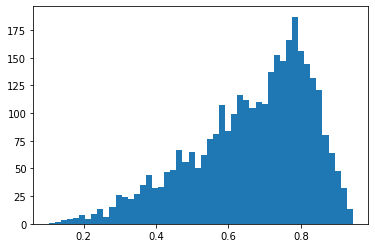

In [ ]:
plt.hist(qed_vals, bins = 50)
plt.show

In [ ]:
def postprocess(input_file, output_file):

    # read in the input file
    with open(input_file, 'r') as f:
        smiles = [r.rstrip() for r in f]

    print(f'Input SMILES num: {len(smiles)}')
    print('Performing SMILES validation ...')
    smiles_val, valids = [], []
    for i in range(len(smiles)):
        smi = smiles[i]
        mol = Chem.MolFromSmiles(smi)
        #check if valid molecule
        if mol:
            try:
              qed_val = QED.qed(mol)
              if qed_val >= 0.586:
                valids.append(smi)
            except:
              print('error')
        else:
            continue
    smiles_val.extend(valids)

    #save output
    print("Creating SMILES output file ...")
    with open(output_file, 'w') as f:
        for smi in smiles_val:
            f.write(smi + '\n')

    print(f'Output SMILES num: {len(smiles_val)}')
    print("Smiles Validation Complete")
    return

In [ ]:
postprocess('/content/generated_smiles_nextgen_PDGFRAGen1.csv','nextgen_smiles_cleaned_PDGFRAGen1')